In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import dataframe_image as dfi
#Dependencies
import gensim #the library for Topic modelling
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models

from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.simplefilter('ignore')
from itertools import chain


#123
user_file = "C:\\Users\\zachi\\Desktop\\final_project_22\\data_nov_21.xlsx"
df=pd.read_excel(user_file)


In [2]:
#remove column - "removed 1"

df.drop(columns=['Removed 1'],inplace=False)

,Category,Removed,חותמת זמן,First name,Last (family) name,Platform,Language,Content Link,Other language? Please specify below.,Reported?,Please upload a screenshot of the content,A short summary of the content- write briefly in your own words,Email address,Country where content published,Age of user
0,Y,Not Removed,2021-10-30 00:29:11.303,polly,golod,Twitter,Russian,https://twitter.com/V_Makvik/status/1450042686...,NaN,Yes,https://drive.google.com/open?id=1syl-cJGE0bO9...,holocaust denial,golodpolina98@gmail.com,Russia,NaN
1,Y,Not Removed,2021-10-30 00:32:57.780,polly,golod,Twitter,Russian,https://twitter.com/neuroserge/status/14471302...,NaN,Yes,https://drive.google.com/open?id=1ao8XZuPaGLbw...,saying that the holocaust wouldnt happen if th...,golodpolina98@gmail.com,Russia,NaN
2,Y,Not Removed,2021-10-30 00:41:00.432,polly,golod,Twitter,Russian,https://twitter.com/5TDkjZlhlPqB6zc/status/144...,NaN,Yes,https://drive.google.com/open?id=1iL4zm6BUEJpf...,holocaust denial,golodpolina98@gmail.com,Russia,NaN
3,Y,Not Removed,2021-10-30 00:51:42.384,polly,golod,Twitter,Russian,https://twitter.com/PolskaSotnja/status/143959...,NaN,Yes,https://drive.google.com/open?id=1vpXv7HZKHIDP...,saying that there was no Holocaust and that it...,golodpolina98@gmail.com,Russia,NaN
4,Y,Not Removed,2021-10-30 01:02:50.037,Irena,Kalika,VK,Russian,https://vk.com/wall503758057_10269,NaN,Yes,https://drive.google.com/open?id=1XnaJsHX8eZPK...,Saying jews are demons,irakalika85@gmail.com,Russia,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Y,Not Removed,2021-11-30 11:06:54.863,Liam,Menache,Twitter,English,https://twitter.com/Frontlet_615/status/144970...,French and Dutch,NaN,https://drive.google.com/open?id=1f9WNsyE6fxGw...,User claims a quote by a rabbi that the jews w...,liam8110@gmail.com,European Union,NaN
306,Y,Not Removed,2021-11-30 11:25:35.082,Liam,Menache,Twitter,English,https://twitter.com/EmpyUnplugged/status/14276...,NaN,NaN,https://drive.google.com/open?id=1eF-_3YcYwPFC...,"Says that other than the ""holohaux"" which is h...",liam8110@gmail.com,United Kingdom,NaN
307,Y,Not Removed,2021-11-30 22:02:31.805,Irena,Kalika,Twitter,English,https://twitter.com/being_khan1010/status/1301...,NaN,NaN,https://drive.google.com/open?id=1ahaRnRopBHQw...,Claiming that us trying to make Muslims inferi...,irakalika85@gmail.com,"Asia (for example: Pakistan, India...)",NaN
308,Y,Not Removed,2021-11-30 22:15:38.247,Irena,Kalika,Twitter,English,https://twitter.com/miraquib0072/status/139237...,NaN,NaN,https://drive.google.com/open?id=1oTmP02zaBsk0...,Promote Natzism and genocide of jews. #killjews,irakalika85@gmail.com,Unknown,NaN


In [3]:
#make category easier to understand 

df=df.replace({'Category' : { 'Y' : "Antisemitic", 'W' : "Non-Antisemitic", 'U' : "Anti-Zionist" }})


In [4]:
#convert "time stamp" to english

df = df.rename(columns={"חותמת זמן":"Time stamp"})


In [5]:
#df.columns

In [6]:
#fix summary column texts

df = df.replace(r'\n',' ', regex=True) 

post_description=df["A short summary of the content- write briefly in your own words "]


In [7]:
#change the date time to the d/m/y

from datetime import datetime
df['Time stamp'] = pd.to_datetime(df['Time stamp'], errors='coerce') #This function convert the date text into dt.date type


תכנים לפי רשת - גרף עמודות ויזואלי לניטור התכנים לפי רשתות ולפי תקופה

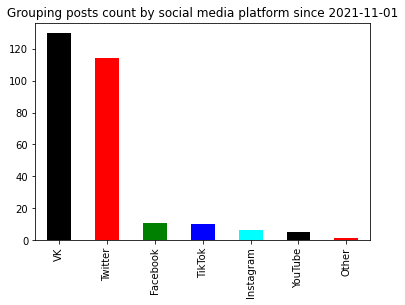

In [8]:
user_input = "2021-11-01"
the_user_target_date = df["Time stamp"]>user_input
new_df = df[the_user_target_date]
posts_in_platforms = new_df["Platform"].value_counts().plot(kind="bar",color=['black', 'red', 'green', 'blue', 'cyan'],title = "Grouping posts count by social media platform since" + " " + user_input)

plt.savefig("posts_in_platforms.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


In [9]:
#get rid of nAns in category

list = ["Anti-Zionist",
"Antisemitic",
"Non-Antisemitic"]

df = df.loc[df['Category'] .isin(list)]
#This line is keeping rows which have one of the categories


סוג התוכן- גרף עמודות שיפלטר את סוגי התכנים פר הרשת החברתית שמקבלת את הדוח

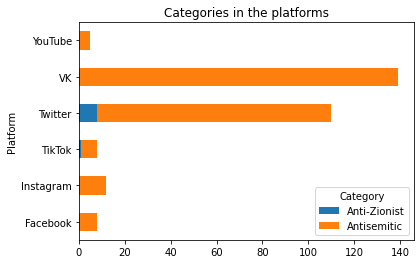

In [10]:

df_group_=df.groupby(['Category', 'Platform'])['Platform'].count().unstack('Category').fillna(0).astype(int)
categories_per_each_platform = df_group_.plot(kind='barh', stacked=True,mark_right = True ,title = "Categories in the platforms")


plt.savefig("categories_per_each_platform.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

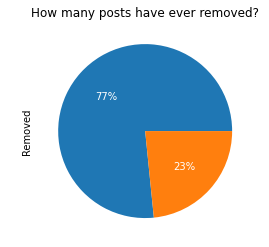

In [11]:
#Cheking the percentage of posts removing in general view

status = df["Removed"]

#df.groupby("Category").agg({status:"mean"})

category = df["Category"]


general_removal_view = status.value_counts() #get general info about the removal process of platforms

general_removal_view_plot = general_removal_view.plot(kind = "pie" , autopct='%1.0f%%', title = "How many posts have ever removed?", textprops={'color':"w"}) 


plt.savefig("general_removal_view_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

נתונים על הסרת התכנים- לפי סוג תוכן (כמה מכל סוג תוכן הוסרו וכמה נשארו)

In [12]:
df.groupby(['Category', 'Removed'])['Removed'].count().unstack('Removed').fillna(0).astype(int)

#set the columns in chronogical order ##

Removed,Not Removed,Removed
Category,,
Anti-Zionist,9,0
Antisemitic,207,66


In [13]:
#This function is grouping the DF by the removal status & the category
outpot_category_removal_stats= df.groupby(['Removed', 'Category'])['Category'].count().unstack('Category').fillna(0).astype(int).reindex(index = ['Removed','Not Removed'])

In [14]:
outpot_category_removal_stats_plot = outpot_category_removal_stats.astype("int")

dfi.export(outpot_category_removal_stats_plot,"outpot_category_removal_stats_plot.png")


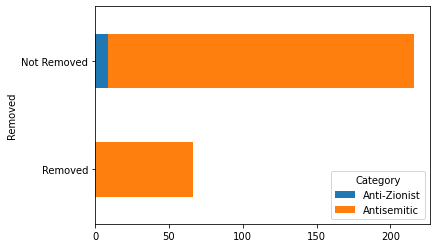

In [15]:
outpot_category_removal_stats_plot = outpot_category_removal_stats.plot(kind='barh', stacked=True,mark_right = True )

plt.savefig("outpot_category_removal_stats_plot.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)


אחוזים לפי כל רשת חברתית - כמה תכנים הוסרו מול כמה נשארו


In [16]:
outpot_category_removal_stats_by_platform= df.groupby(['Removed', 'Platform'])['Platform'].count().unstack('Platform').fillna(0).astype(int).reindex(index = ['Removed','Not Removed'])

In [17]:
precentage_chart = outpot_category_removal_stats_by_platform/outpot_category_removal_stats_by_platform[outpot_category_removal_stats_by_platform.columns].sum()*100


In [18]:
precentage_chart_plot = precentage_chart.round(1).astype(str) +'%'

dfi.export(precentage_chart_plot,"precentage_chart_plot.png")


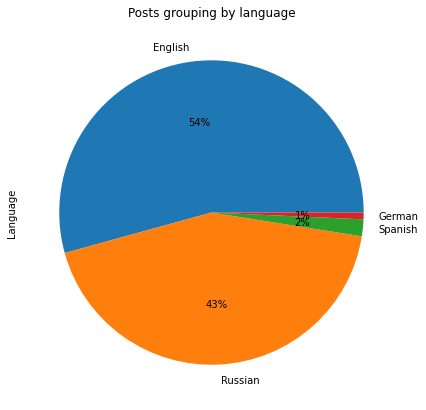

In [19]:
language = df["Language"]

pie_chart = df["Language"].value_counts().head(4).plot(kind = "pie",figsize=(15, 7),title = "Posts grouping by language",autopct='%1.0f%%')


plt.savefig("sort_by_language.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

מילות מפתח בתכנים שהוסרו (בלבד)



In [20]:
#Tokenization process - 
#1. Lowercasing
#2. Translate all words, in any languge - to English
#3. Exclude Stop Words
#4. Identifaing n-grams
#5. Deal with hashtags
#6. Word frequency - think about how to deal with terms which appear multiple times via the text

In [21]:
posts_description = df["A short summary of the content- write briefly in your own words "]

In [22]:
only_removed_content = df["Removed"]!="Not Removed"

In [23]:
only_removed_content = df[only_removed_content]


In [24]:
posts_description = only_removed_content["A short summary of the content- write briefly in your own words "]


In [25]:

posts_description = posts_description.str.lower()

In [26]:
posts_description = posts_description.str.replace('[^\w\s]','')

In [27]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
stop = stopwords.words('english')
new_list=["picture","video","pic","cartoon","photo","int","dtype","Claiming","claiming","dtype","int64"," int64"]
stop.extend(new_list)

desc_column_without_sw = posts_description.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [29]:
from collections import Counter


In [30]:
desc_column_without_sw = pd.Series(' '.join(desc_column_without_sw).split()).value_counts()[:15]
desc_column_without_sw



jews            55
control          7
jewish           6
genocide         6
claims           6
hitler           4
anti             4
blaming          4
jew              4
ppl              4
antisemitism     4
world            4
media            3
planning         3
government       3
dtype: int64

In [31]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


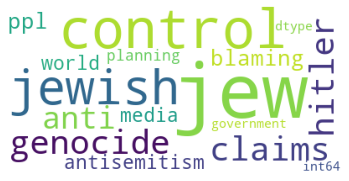

In [32]:
wordcloud = WordCloud(collocations = False, background_color = 'white').generate(str(desc_column_without_sw))

plt.imshow(wordcloud)
plt.axis("off")


plt.savefig("wordcloud.png",dpi='figure',
        bbox_inches= 'tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None)

In [33]:
from matplotlib.backends.backend_pdf import PdfPages
from fpdf import FPDF


pdf = FPDF()

pdf.add_page()

pdf.set_font('Arial', size = 16)

pdf.cell(40)

pdf.cell(75, 10,'Inner report', 0, 2, 'C')

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(-20)

pdf.image("posts_in_platforms.png")

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(-20)


pdf.image("sort_by_language.png")

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(10)

pdf.image("categories_per_each_platform.png")

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(10)

pdf.image("general_removal_view_plot.png")

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(5)

pdf.image("outpot_category_removal_stats_plot.png")

pdf.cell(100, 10, '', 0, 2, 'C')
pdf.cell(-14)

pdf.image("precentage_chart_plot.png")

pdf.cell(90, 10, '', 0, 2, 'C')
pdf.cell(20)

pdf.image("wordcloud.png")

pdf.output("Inner report.pdf")



''